<a href="https://colab.research.google.com/github/foxyreign/AAA_Movie/blob/main/Data_Strategy_Plan_for_AAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Strategy Plan for AAA**


---



# Dataset Preparation

Three datasets are downloaded and extracted directly from IMDB live database:

1.   Title Basics - contains the title, year of release and genres. Only movies are selected.
2.   Title Ratings - contains the weighted average rating and number of votes.

Since IMDB database does not have the datasets needed for actor ratings and other analyses, several external public datasets were used to supplement.

Due to RAM restrictions, each of the dataset is extracted one by one and any unnecessary files and variables were deleted after.

In [1]:
# Download gz files
basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

!wget {basics}
!wget {ratings}

--2024-06-02 11:41:06--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.163.50, 13.224.163.65, 13.224.163.104, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.163.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189662689 (181M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 180.88M  49.0MB/s    in 3.9s    

2024-06-02 11:41:10 (46.7 MB/s) - ‘title.basics.tsv.gz’ saved [189662689/189662689]

--2024-06-02 11:41:10--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.163.50, 13.224.163.65, 13.224.163.104, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.163.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7252826 (6.9M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================

Basics dataset

In [2]:
import gzip
import pandas as pd
import os

# Set chunk size
chunk_size = 8192

# Extract dataset one by one due to RAM restriction and remove unnecessary files
# basics
with gzip.open('title.basics.tsv.gz', 'rb') as f_in:
  with open('basics.txt', 'wb') as f_out:
    chunk = f_in.read(chunk_size)
    while chunk:
      f_out.write(chunk)
      chunk = f_in.read(chunk_size)

# Load akas dataset
basics_df = pd.read_csv('basics.txt', sep='\t',
                        usecols=['tconst','titleType','primaryTitle','startYear','genres'])

# Remove unnecessary files
os.remove('basics.txt')
os.remove('title.basics.tsv.gz')

# Retain movies only
movies_df = basics_df[basics_df['titleType']=='movie']

# Expand genres column to multiple columns
genres = movies_df['genres'].str.split(',', expand=True)
genres.columns = ['genre_1','genre_2','genre_3']

# Merge movies_df and genres, delete genres dataset
movies_df = pd.merge(movies_df, genres, left_index=True, right_index=True)
del(genres)

# Delete genres column from movies_df
movies_df = movies_df.drop('genres', axis=1)

# Replace \N with null
movies_df['genre_1'] = movies_df['genre_1'].str.replace('\\N', '')
movies_df['genre_2'] = movies_df['genre_2'].str.replace('None', '')
movies_df['genre_3'] = movies_df['genre_3'].str.replace('None', '')

# Create dataset of movies in 2020
movies_2020_df = movies_df[movies_df['startYear']=='2020']

Ratings

In [3]:
import gzip
import pandas as pd
import os

# Set chunk size
chunk_size = 4096

# ratings
with gzip.open('title.ratings.tsv.gz', 'rb') as f_in:
  with open('ratings.txt', 'wb') as f_out:
    chunk = f_in.read(chunk_size)
    while chunk:
      f_out.write(chunk)
      chunk = f_in.read(chunk_size)

# Load basics dataset
ratings_df = pd.read_csv('ratings.txt', sep='\t')

# Merge movies in 2020 and ratings
movies_2020_df = pd.merge(movies_2020_df, ratings_df, how='left',
                          left_index=True, right_index=True)

# Remove unnecessary files
#os.remove('ratings.txt')
#os.remove('title.ratings.tsv.gz')

Actors

The actors dataset is saved on my Google Drive that can be publicly accessed.

# Exploratory Data Analysis

**Highest Rated Movie of 2020**

Each movie title is given a weighted average of all the individual user ratings.

In an unbalanced number of votes across different movie titles, a very popular movie could have multiple votes while a niche movie would result to limited number of votes. The latter would be more sensitive to fluctuation of the averages while the former would have stable average value as the law of large numbers would apply.

To balance the ratings with the number of votes, compute the Bayesian rating (which is the weighted rating of movie titles based on number of votes) per distribution grouping of number of votes.

\begin{equation}
WeightedRating = (\frac{votes}{votes+top1000})*rating+(\frac{top100}{votes+top1000})*rating_{avg}
\end{equation}

For this analysis, only top 10 movies will be selected among the top 1,000 movies.

In [4]:
# Compute weighted rating
top = 1000 # Set top 1000 movies
movies_2020_df['wr'] = (movies_2020_df['numVotes']/(movies_2020_df['numVotes']+top))*movies_2020_df['averageRating']+(top/(movies_2020_df['numVotes']+top))*movies_2020_df['averageRating'].mean()
movies_2020_df['wr'] = movies_2020_df['wr'].round(2)

In [5]:
movies_2020_df

,tconst_x,titleType,primaryTitle,startYear,genre_1,genre_2,genre_3,tconst_y,averageRating,numVotes,wr
61107,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,Drama,None,None,tt0084600,6.5,257.0,6.98
122045,tt0125366,movie,Lifepod,2020,Sci-Fi,Thriller,None,tt0178917,4.8,31.0,7.03
220818,tt0230622,movie,Parinati,2020,Drama,None,None,tt0387183,7.3,26.0,7.11
233827,tt0244158,movie,Radha Krishna,2020,Drama,None,None,tt0416429,8.1,9.0,7.11
280901,tt0293513,movie,"Pit Bull: A Tale of Lust, Murder and Revenge",2020,,None,None,tt0525295,7.4,12.0,7.11
...,...,...,...,...,...,...,...,...,...,...,...
10816959,tt9913288,movie,Letters,2020,Drama,None,None,NaN,NaN,NaN,NaN
10817380,tt9914192,movie,No Gogó do Paulinho,2020,Comedy,None,None,NaN,NaN,NaN,NaN
10818268,tt9916190,movie,Safeguard,2020,Action,Adventure,Thriller,NaN,NaN,NaN,NaN
10818307,tt9916270,movie,Il talento del calabrone,2020,Thriller,None,None,NaN,NaN,NaN,NaN


[Text(0, 0, '9.04'),
 Text(0, 0, '9.01'),
 Text(0, 0, '8.88'),
 Text(0, 0, '8.7'),
 Text(0, 0, '8.68'),
 Text(0, 0, '8.56'),
 Text(0, 0, '8.53'),
 Text(0, 0, '8.49'),
 Text(0, 0, '8.49'),
 Text(0, 0, '8.41')]

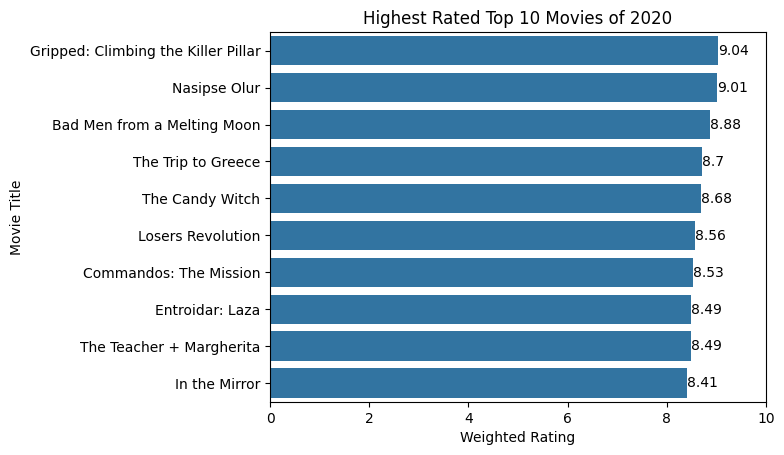

In [6]:
# Top 10 movies base on weighted rating
import seaborn as sns
import numpy as np

# Create barplot
top10_movies = sns.barplot(y='primaryTitle',x='wr',
                            data=movies_2020_df.nlargest(10,'wr'))

# Set figure options
top10_movies.set(xlabel='Weighted Rating',ylabel='Movie Title',
                 title='Highest Rated Top 10 Movies of 2020',
                 xlim=(0,10))

# Add weighted rating labels
top10_movies.bar_label(top10_movies.containers[0])
